Download example vectors from https://github.com/erikbern/ann-benchmarks

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import mkl

os.environ["OMP_NUM_THREADS"] = "6"
os.environ["MKL_NUM_THREADS"] = "6"
os.environ["OPENBLAS_NUM_THREADS"] = "6"

mkl.set_num_threads(6)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import h5py
import numpy as np
data = h5py.File('nytimes-256-angular.hdf5', 'r')

In [4]:
def normalize(x):
    return x / (np.linalg.norm(x, axis=1).reshape(-1, 1) + 1e-5)

train_embeddings = data['train'][:]
test_embeddings = data['test'][:]
exact_indices = data['neighbors'][:, 0]

train_embeddings = normalize(train_embeddings)
test_embeddings = normalize(test_embeddings)

In [5]:
d = test_embeddings.shape[1]
d, train_embeddings.shape, test_embeddings.shape

(256, (290000, 256), (10000, 256))

# Build index

In [11]:
from fast_ivf import FastIVF
nlist = 1024
index = FastIVF(d, nlist=nlist, kmeans_batch_size=1024)
index.train(train_embeddings)

Convergence delta = 0.00011: 100%|██████████| 1000/1000 [00:05<00:00, 179.30it/s]
Assigning: 284it [00:00, 786.11it/s]                         


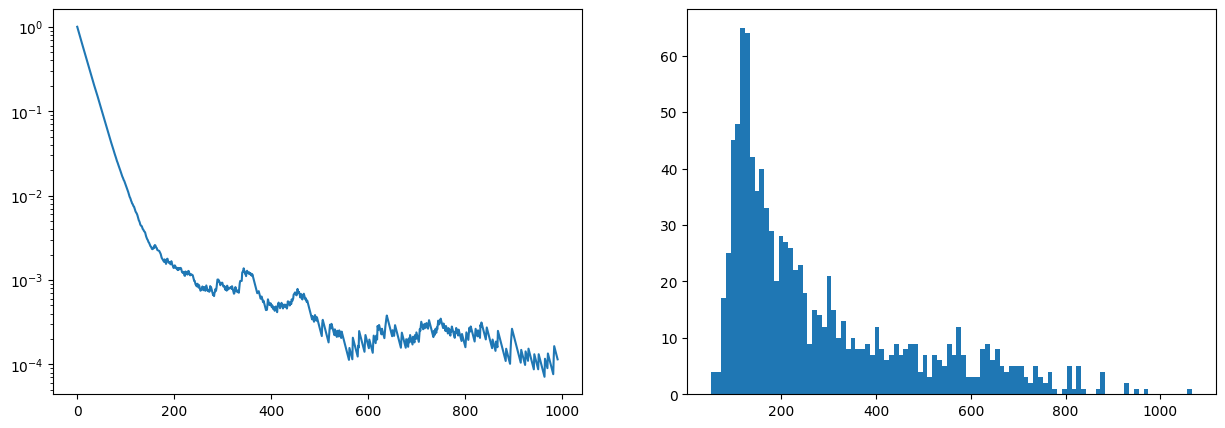

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(index.kmeans._history)
plt.yscale("log")
plt.subplot(1, 2, 2)
indices, counts = np.unique(index.kmeans._labels, return_counts=True)
plt.hist(counts, 100);

# Evaluate index

In [13]:
index.search(test_embeddings[:10], k=100);

In [15]:
index.nprobe = 10
index.ratio_threshold = 0.5
distances, indices = index.search(test_embeddings, k=100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.8295

In [16]:
%timeit index.search(test_embeddings, k=100)

505 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Compare with Faiss IVF Index

In [17]:
import faiss

d = train_embeddings.shape[1]
nlist = 1024

quantizer = faiss.IndexFlatIP(d)
faiss_index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
faiss_index.train(train_embeddings)
faiss_index.add(train_embeddings)

In [18]:
faiss_index.nprobe = 10
distances, indices = faiss_index.search(test_embeddings, 100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.8394

In [19]:
%timeit faiss_index.search(test_embeddings, 100)

781 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Compressed IVF index

In [20]:
from fast_ivf import CompressedFastIVF

index = CompressedFastIVF(d, nlist=1024, compression_ndim=128, compressor_steps_per_epoch=1000)
index.train(train_embeddings)

2023-10-29 17:03:53.149857: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 17:03:53.177100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 17:03:53.751996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-29 17:03:54.671491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-29 17:03:54.671520: I tensorflow/compiler/xla/stream_executor/cuda/

Training compressor steps_per_epoch=1000 epoch=10 compression_ndim=128
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.7140 - categorical_accuracy: 0.3553 - top_k_categorical_accuracy: 0.6049
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 2.1786 - categorical_accuracy: 0.5503 - top_k_categorical_accuracy: 0.8136
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 1.8514 - categorical_accuracy: 0.6026 - top_k_categorical_accuracy: 0.8583
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7466 - categorical_accuracy: 0.6209 - top_k_categorical_accuracy: 0.8733
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6715 - categorical_accuracy: 0.6347 - top_k_categorical_accuracy: 0.8839
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6418 - categorical_accuracy: 0.6385 - top_k_categorical_accuracy: 0.8882
Epoch 7/10
1000/1000 [=

Adding compressed vectors: 284it [00:00, 908.33it/s]


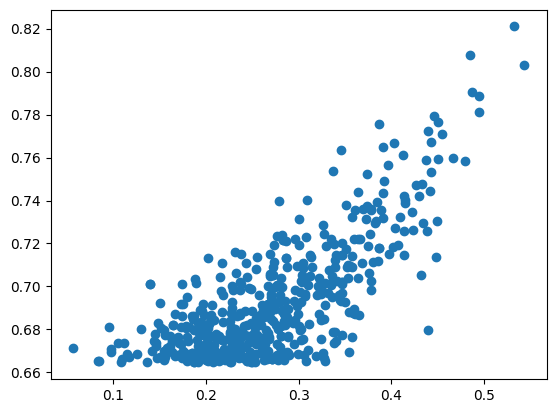

In [21]:
index.nprobe = 400
distances, indices = index.search(test_embeddings[:100], k=500, rescore=False)

idx = 1
query = test_embeddings[idx]
exact_distances = train_embeddings[indices[idx]] @ query

plt.scatter(exact_distances, distances[idx])

In [26]:
index.nprobe = 10
index.ratio_threshold = 0.5
index.rescore_num_samples = -1
distances, indices = index.search(test_embeddings, k=100, rescore=False)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.7685

In [30]:
%timeit index.search(test_embeddings, k=100, rescore=False)

465 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


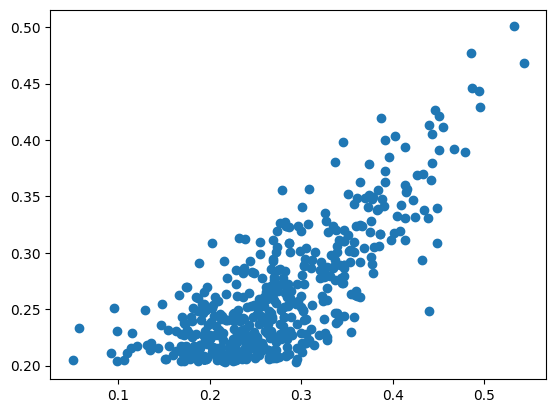

In [28]:
index.rescore_num_samples = 50
distances, indices = index.search(test_embeddings[:100], k=500, rescore=True)
idx = 1
query = test_embeddings[idx]
exact_distances = train_embeddings[indices[idx]] @ query
plt.scatter(exact_distances, distances[idx])

# FastIVFPQ

In [37]:
from fast_ivf import FastIVFPQ

index = FastIVFPQ(d, nlist=1024, pq_num_subvectors=32, pq_num_centroids=64)
index.train(train_embeddings)

Convergence delta = 0.86334:   0%|          | 0/1000 [00:00<?, ?it/s]

Convergence delta = 0.00010:  46%|████▌     | 458/1000 [00:01<00:01, 287.53it/s]
Assigning: 567it [00:00, 944.18it/s]                         
Convergence delta = 0.00010:  73%|███████▎  | 7300/10000 [00:11<00:04, 625.40it/s]
Assigning: 4532it [00:01, 2714.40it/s]                          


In [38]:
index.nprobe = 10
index.ratio_threshold = 0.5
index.rescore_num_samples = -1
distances, indices = index.search(test_embeddings, k=100, rescore=False)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.7517

In [39]:
%timeit index.search(test_embeddings, k=100, rescore=False)

467 ms ± 9.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
nlist = 1024
m = 32
n_bits = 6 # 2 ** 6 = 64 centroids per subvector

faiss_index = faiss.IndexIVFPQ(faiss.IndexFlatIP(d), d, nlist, m, n_bits)
faiss_index.train(train_embeddings)
faiss_index.add(train_embeddings)

In [41]:
faiss_index.nprobe = 10
distances, indices = faiss_index.search(test_embeddings, 100)

accuracies = []
for i, qi in enumerate(indices):
    acc = exact_indices[i] in qi[:10]
    accuracies.append(acc)
np.mean(accuracies)

0.7247

In [42]:
%timeit faiss_index.search(test_embeddings, 100)

1.72 s ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
